In [2]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
from dask.distributed import Client
from dask_jobqueue import PBSCluster

import os
%matplotlib inline

In [2]:
import socket
import fcntl
import struct
def get_interface_ip(ifname):
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    return socket.inet_ntoa(fcntl.ioctl(
            s.fileno(),
            0x8915,
            struct.pack('256s', bytes(ifname[:15], 'utf-8'))
        )[20:24])

In [3]:
cluster = PBSCluster(cores=8, memory='50 GB', ip=get_interface_ip('ib0'), dashboard_address=get_interface_ip('vlan192'))
cluster

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://10.9.105.1:43442 Dashboard: http://10.9.105.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.job_header = '#!/usr/bin/env bash\n#PBS -N dask-worker\n#PBS -q expressbw\n#PBS -l ncpus=8\n#PBS -l mem=50GB\n#PBS -l walltime=00:30:00\nJOB_ID=${PBS_JOBID%.*}'

In [6]:
path='/g/data1a/x77/amh157/OCCIPUT/SSH_ENSEMBLE_all/ORCA025.L75-OCCITENS.{0:03}-S/1d/'

In [7]:
cluster.scale(10)

In [8]:
output='/home/156/jm5970/data/trackeddy_output/OCCIPUT/pre-processing'

In [9]:
ii=23
ncfiles = sorted([os.path.join(path.format(ii), f) for f in os.listdir(path.format(ii)) if os.path.isfile(os.path.join(path.format(ii), f))])

In [10]:
counter=0
for file in ncfiles:
    if counter==0:
        data0 = xr.open_dataset(file,chunks={'time_counter':100, 'y':510, 'x':721}).drop('nav_lat').drop('nav_lon')
        counter=1
    else:
        data1 = xr.open_dataset(file,chunks={'time_counter':100, 'y':510, 'x':721}).drop('nav_lat').drop('nav_lon')
        data0 = xr.concat([data0,data1],dim='time_counter')

In [11]:
data_coord = xr.open_dataset(file,chunks={'time_counter':100, 'y':510, 'x':721})

In [12]:
data0

<xarray.Dataset>
Dimensions:               (time_bounds: 2, time_counter: 7670, x: 1442, y: 1021)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(7670,), chunksize=(100,)>
  * time_counter          (time_counter) datetime64[ns] 1995-01-01T12:00:00 ... 2015-12-31T12:00:00
Dimensions without coordinates: time_bounds, x, y
Data variables:
    time_centered_bounds  (time_counter, time_bounds) datetime64[ns] dask.array<shape=(7670, 2), chunksize=(100, 2)>
    time_counter_bounds   (time_counter, time_bounds) datetime64[ns] dask.array<shape=(7670, 2), chunksize=(100, 2)>
    ssh                   (time_counter, y, x) float32 dask.array<shape=(7670, 1021, 1442), chunksize=(100, 510, 721)>
Attributes:
    description:               ocean T grid variables
    conventions:               CF-1.1
    production:                An IPSL model
    start_date:                19600101
    output_frequency:          1d
    CONFIG:                    ORCA025.L75
    

In [13]:
data_t=data0.assign_coords(nav_lat=data_coord.nav_lat)

In [14]:
data_t

<xarray.Dataset>
Dimensions:               (time_bounds: 2, time_counter: 7670, x: 1442, y: 1021)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(7670,), chunksize=(100,)>
  * time_counter          (time_counter) datetime64[ns] 1995-01-01T12:00:00 ... 2015-12-31T12:00:00
    nav_lon               (y, x) float32 dask.array<shape=(1021, 1442), chunksize=(510, 721)>
    nav_lat               (y, x) float32 dask.array<shape=(1021, 1442), chunksize=(510, 721)>
Dimensions without coordinates: time_bounds, x, y
Data variables:
    time_centered_bounds  (time_counter, time_bounds) datetime64[ns] dask.array<shape=(7670, 2), chunksize=(100, 2)>
    time_counter_bounds   (time_counter, time_bounds) datetime64[ns] dask.array<shape=(7670, 2), chunksize=(100, 2)>
    ssh                   (time_counter, y, x) float32 dask.array<shape=(7670, 1021, 1442), chunksize=(100, 510, 721)>
Attributes:
    description:               ocean T grid variables
    conventions:

In [15]:
ssh_mean=data_t.ssh.mean(dim="time_counter").compute()

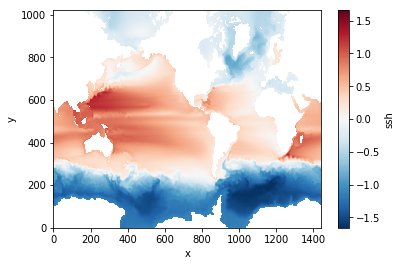

In [16]:
ssh_mean.plot()

In [17]:
ssh_mean.to_netcdf('/home/156/jm5970/data/trackeddy_output/OCCIPUT/pre-processing/non-interp_ORCA025.L75-OCCITENS.043_y_mean.nc')

In [18]:
print(data_t.nav_lon.shape)
if len(data_t.nav_lon.shape)==3:
    lat=data_t.nav_lat.isel(time_counter=0).values
    lon=data_t.nav_lon.isel(time_counter=0).values
else:
    lon=data_t.nav_lon.values
    lat=data_t.nav_lat.values

(1021, 1442)


In [19]:
x=np.linspace(-180,180,np.shape(lon)[1])
y=np.linspace(-90,90,np.shape(lon)[0])
X,Y=np.meshgrid(x,y)
print(ssh_mean.shape)


(1021, 1442)


In [ ]:
interp_data=griddata((lon.ravel(),lat.ravel()),ssh_mean.values.ravel(),(X,Y),'linear')

In [ ]:
print('Data interpolated')
mean_ssh['ssh']=(('y','x'), interp_data) 
mean_ssh['nav_lat']=('y',y)
mean_ssh['nav_lon']=('x',x)
mean_ssh.ssh.to_netcdf(output_path+'ORCA025.L75-OCCITENS.{0:03}_y_mean.nc'.format(ii))

In [ ]:
for ii in range(23,50):
    print((path+"ORCA025.L75-OCCITENS.{0:03}_y*.1d_SSH.nc").format(ii))
    data = xr.open_mfdataset((path+"ORCA025.L75-OCCITENS.{0:03}_y*.1d_SSH.nc").format(ii),coords='minimal',chunks={'time_counter':100, 'y':510, 'x':721}).ssh.drop('nav_lat').drop('nav_lon')
    mean_ssh=data.ssh.mean(dim="time_counter").compute()
    mean_ssh.to_netcdf((output+'ORCA025.L75-OCCITENS.{0:03}_y_mean.nc').format(ii))
    #lon=data.nav_lon.values
    #lat=data.nav_lat.values

/g/data1a/x77/amh157/OCCIPUT/SSH_ENSEMBLE_all/ORCA025.L75-OCCITENS.023-S/1d/ORCA025.L75-OCCITENS.023_y*.1d_SSH.nc


In [ ]:
data

In [1]:
client.close()
cluster.close()

NameError: name 'client' is not defined

In [ ]:
1021/2

In [8]:
ii=1
data = xr.open_mfdataset((path+"ORCA025.L75-OCCITENS.{0:03}_y*.1d_SSH.nc").format(ii),chunks={'time_counter':365, 'y':510, 'x':721})

In [10]:
lat=data.nav_lat.values

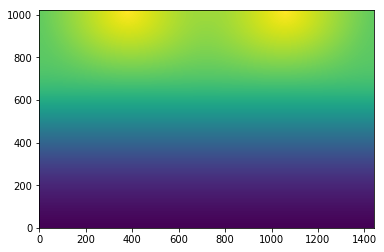

In [14]:
plt.pcolormesh(lat)

In [13]:
import pylab as plt

In [1]:
365*20


7300